## 1) 데이터 준비와 확인

In [1]:
import numpy as np
import pandas as pd
import konlpy
import gensim

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성

In [2]:
from konlpy.tag import Mecab
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
#data loader
def load_data(train_data, test_data, num_words=10000):
    #중복된 리뷰 & 결측값 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    #토크나이징 - 형태소 단위(morphs) & 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X) # [[w, w, w], ... , [w, w, w]]
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    # word_to_idx dictionary
    words = np.concatenate(X_train).tolist() # [w, w, ... , w, w ]
    counter = Counter(words) 
    counter = counter.most_common(10000-4) # 많은 수로 정렬 # -4 : pad, bos, unk, unused
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # word_to_idx for list
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))
        
    return X_train, y_train, X_test, y_test, word_to_index
  

In [3]:
#load train/test data as idx list, dictionary
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("train: {}, test: {}".format(len(X_train), len(X_test)))

train: 146182, test: 49157


In [4]:
# word-idx encoding & decoding
index_to_word = {index:word for word, index in word_to_index.items()}

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공

num tokens mean: 15.96940191154864
num tokens max: 116
num tokens std: 12.843571191092
max length: 100


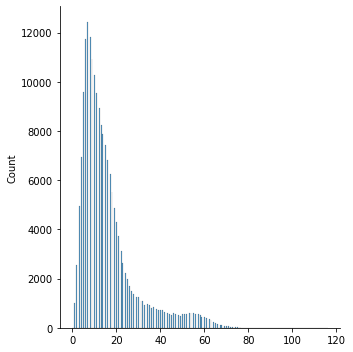

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터셋 내 문장 길이 분포
total_data = X_train + X_test
num_tokens = [len(tokens) for tokens in total_data]
num_tokens = np.array(num_tokens)

print("num tokens mean:", np.mean(num_tokens))
print("num tokens max:", np.max(num_tokens))
print("num tokens std:", np.std(num_tokens))

sns.displot([len(tokens) for tokens in total_data ])

# 적절한 최대 문장 길이 지정
max_len = 100
print("max length:", max_len)

In [6]:
# 패딩 추가
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')
print(X_train.shape)

(146182, 100)


## 4) 모델 구성 및 validation set 구성

In [7]:
# 모델 구성: LSTM, 1D-CNN, Bidirectional LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional

num_words = 10000
word_vector_dim = 200

model_lstm = Sequential(name='LSTM')
model_lstm.add(Embedding(num_words, word_vector_dim, name='emb'))
model_lstm.add(LSTM(64, name='lstm'))
model_lstm.add(Dense(64, activation='relu', name='d_rel'))
model_lstm.add(Dense(1, activation='sigmoid', name='d_sig'))

model_cnn = Sequential(name='1D_CNN')
model_cnn.add(Embedding(num_words, word_vector_dim, name='emb'))
model_cnn.add(Conv1D(128, 7, activation='relu', name='conv1d'))
model_cnn.add(GlobalMaxPooling1D(name='global_max_pooling1d'))
model_cnn.add(Dense(64, activation='relu', name='d_rel'))
model_cnn.add(Dense(1, activation='sigmoid', name='d_sig'))

model_bi_lstm = Sequential(name='Bidirectional_LSTM')
model_bi_lstm.add(Embedding(num_words, word_vector_dim, name='emb'))
model_bi_lstm.add(Bidirectional(LSTM(64, name='bi_lstm')))
model_bi_lstm.add(Dense(64, activation='relu', name='d_rel'))
model_bi_lstm.add(Dense(1, activation='sigmoid', name='d_sig'))

model_lstm.summary()
model_cnn.summary()
model_bi_lstm.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb (Embedding)              (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                67840     
_________________________________________________________________
d_rel (Dense)                (None, 64)                4160      
_________________________________________________________________
d_sig (Dense)                (None, 1)                 65        
Total params: 2,072,065
Trainable params: 2,072,065
Non-trainable params: 0
_________________________________________________________________
Model: "1D_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
emb (Embedding)              (None, None, 200)         2000000   
____________________________________

In [8]:
#validation set 구성
val_size = int(len(X_train) * 0.2)

X_val = X_train[:val_size]
y_val = y_train[:val_size]

X_train = X_train[val_size:]
y_train = y_train[val_size:]

## 5) 모델 훈련 개시

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

es_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc_lstm = ModelCheckpoint('best_model.lstm', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es_lstm, mc_lstm])

es_cnn = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc_cnn = ModelCheckpoint('best_model.cnn', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_cnn = model_cnn.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es_cnn, mc_cnn])

es_bi_lstm = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc_bi_lstm = ModelCheckpoint('best_model.bi_lstm', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model_bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_bi_lstm = model_bi_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es_bi_lstm, mc_bi_lstm])

Epoch 1/10
3655/3655 [==============================] - 27s 7ms/step - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.4976

Epoch 00001: val_acc improved from -inf to 0.49761, saving model to best_model.lstm


INFO:tensorflow:Assets written to: best_model.lstm/assets


INFO:tensorflow:Assets written to: best_model.lstm/assets


Epoch 2/10
3655/3655 [==============================] - 26s 7ms/step - loss: 0.6932 - acc: 0.4974 - val_loss: 0.6931 - val_acc: 0.5024

Epoch 00002: val_acc improved from 0.49761 to 0.50239, saving model to best_model.lstm


INFO:tensorflow:Assets written to: best_model.lstm/assets


INFO:tensorflow:Assets written to: best_model.lstm/assets


Epoch 3/10
3655/3655 [==============================] - 26s 7ms/step - loss: 0.6931 - acc: 0.5024 - val_loss: 0.6932 - val_acc: 0.4976

Epoch 00003: val_acc did not improve from 0.50239
Epoch 4/10
3655/3655 [==============================] - 26s 7ms/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6931 - val_acc: 0.5024

Epoch 00004: val_acc did not improve from 0.50239
Epoch 5/10
3655/3655 [==============================] - 25s 7ms/step - loss: 0.6931 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.5024

Epoch 00005: val_acc did not improve from 0.50239
Epoch 00005: early stopping
Epoch 1/10
3655/3655 [==============================] - 21s 5ms/step - loss: 0.3572 - acc: 0.8406 - val_loss: 0.3120 - val_acc: 0.8655

Epoch 00001: val_acc improved from -inf to 0.86554, saving model to best_model.cnn
INFO:tensorflow:Assets written to: best_model.cnn/assets


INFO:tensorflow:Assets written to: best_model.cnn/assets


Epoch 2/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.2496 - acc: 0.8961 - val_loss: 0.3288 - val_acc: 0.8647

Epoch 00002: val_acc did not improve from 0.86554
Epoch 3/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.1620 - acc: 0.9358 - val_loss: 0.3737 - val_acc: 0.8619

Epoch 00003: val_acc did not improve from 0.86554
Epoch 4/10
3655/3655 [==============================] - 18s 5ms/step - loss: 0.0966 - acc: 0.9621 - val_loss: 0.4841 - val_acc: 0.8552

Epoch 00004: val_acc did not improve from 0.86554
Epoch 00004: early stopping
Epoch 1/10
3655/3655 [==============================] - 42s 11ms/step - loss: 0.3648 - acc: 0.8365 - val_loss: 0.3152 - val_acc: 0.8625

Epoch 00001: val_acc improved from -inf to 0.86250, saving model to best_model.bi_lstm


INFO:tensorflow:Assets written to: best_model.bi_lstm/assets


INFO:tensorflow:Assets written to: best_model.bi_lstm/assets


Epoch 2/10
3655/3655 [==============================] - 39s 11ms/step - loss: 0.2758 - acc: 0.8833 - val_loss: 0.3135 - val_acc: 0.8673

Epoch 00002: val_acc improved from 0.86250 to 0.86725, saving model to best_model.bi_lstm


INFO:tensorflow:Assets written to: best_model.bi_lstm/assets


INFO:tensorflow:Assets written to: best_model.bi_lstm/assets


Epoch 3/10
3655/3655 [==============================] - 39s 11ms/step - loss: 0.2271 - acc: 0.9063 - val_loss: 0.3279 - val_acc: 0.8674

Epoch 00003: val_acc improved from 0.86725 to 0.86742, saving model to best_model.bi_lstm


INFO:tensorflow:Assets written to: best_model.bi_lstm/assets


INFO:tensorflow:Assets written to: best_model.bi_lstm/assets


Epoch 4/10
3655/3655 [==============================] - 39s 11ms/step - loss: 0.1814 - acc: 0.9269 - val_loss: 0.3561 - val_acc: 0.8641

Epoch 00004: val_acc did not improve from 0.86742
Epoch 5/10
3655/3655 [==============================] - 39s 11ms/step - loss: 0.1423 - acc: 0.9438 - val_loss: 0.4295 - val_acc: 0.8575

Epoch 00005: val_acc did not improve from 0.86742
Epoch 00005: early stopping


## 6) Loss, Accuracy 그래프 시각화

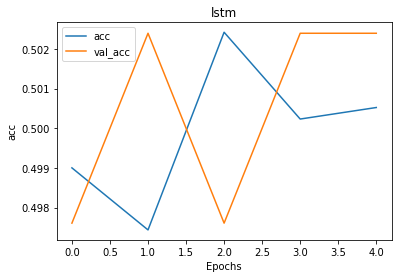

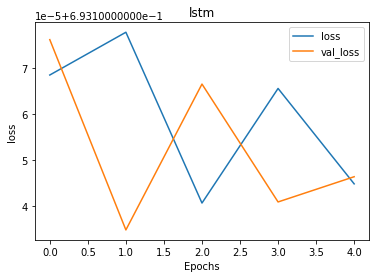

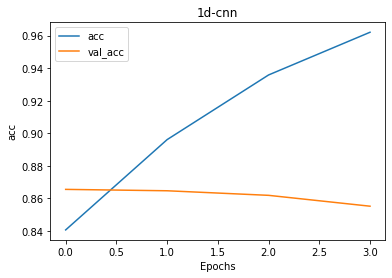

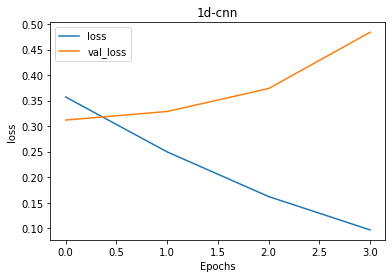

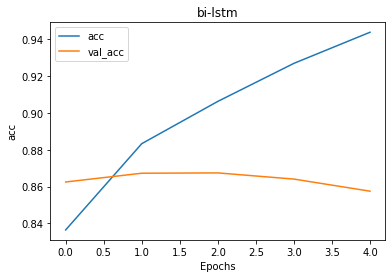

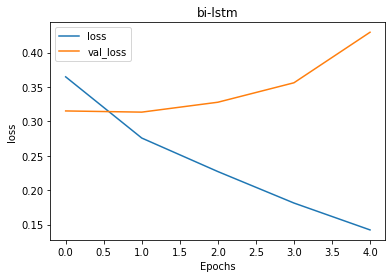

In [12]:
def plot_graphs(history, metric, title):
    plt.title(title)
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

plot_graphs(history_lstm, 'acc', 'lstm')
plot_graphs(history_lstm, 'loss', 'lstm')

plot_graphs(history_cnn, 'acc', '1d-cnn')
plot_graphs(history_cnn, 'loss', '1d-cnn')

plot_graphs(history_bi_lstm, 'acc', 'bi-lstm')
plot_graphs(history_bi_lstm, 'loss', 'bi-lstm')

In [13]:
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test, y_test, verbose=0)
print("LSTM Test Accuracy:", test_accuracy_lstm)

test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test, verbose=0)
print("1D-CNN Test Accuracy:", test_accuracy_cnn)

test_loss_bi_lstm, test_accuracy_bi_lstm = model_bi_lstm.evaluate(X_test, y_test, verbose=0)
print("Bidirectional LSTM Test Accuracy:", test_accuracy_bi_lstm)

LSTM Test Accuracy: 0.4972842037677765
1D-CNN Test Accuracy: 0.8521268367767334
Bidirectional LSTM Test Accuracy: 0.8565616011619568


## 7) 학습된 Embedding 레이어 분석

In [14]:
embedding_layer = model_bi_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 200)


In [51]:
import os
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(10000-4, 200))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_bi_lstm.get_weights()[0]
for i in range(4,10000):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [52]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['야호']
print(vector.shape)

(200,)


In [40]:
word_vectors.similar_by_word("야호")

[('bbbb', 0.8364874720573425),
 ('크리스', 0.8288432955741882),
 ('장동민', 0.825219988822937),
 ('찰리채플린', 0.823055624961853),
 ('잼따', 0.8225897550582886),
 ('앙', 0.8211331963539124),
 ('츠마부키', 0.8124189972877502),
 ('봣습니다', 0.8102415800094604),
 ('깨달음', 0.8097405433654785),
 ('치즈', 0.8080706000328064)]

## 8)한국어 Word2Vec 임베딩 활용하여 성능 개선

In [58]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant


word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word2vec = gensim.models.Word2Vec.load(word2vec_file_path)
word2vec.wv.similar_by_word("야호")

[('마호', 0.7901776432991028),
 ('우키', 0.7638165950775146),
 ('후치', 0.7490092515945435),
 ('키리', 0.7468628287315369),
 ('히나', 0.7463589310646057),
 ('노히', 0.7460137009620667),
 ('우케', 0.7459872364997864),
 ('요우', 0.7446965575218201),
 ('가라스', 0.7432337403297424),
 ('쿠사', 0.7405006289482117)]

???

In [56]:
word2vec.wv.similar_by_word("밥")

[('스폰지', 0.741403341293335),
 ('잼', 0.722240686416626),
 ('딜런', 0.7016739845275879),
 ('레몬', 0.6799979209899902),
 ('쌀밥', 0.6715186238288879),
 ('패티', 0.6604835987091064),
 ('사탕', 0.6595034003257751),
 ('푸딩', 0.6555274128913879),
 ('커리', 0.6538302302360535),
 ('한잔', 0.6525587439537048)]

In [66]:
import numpy as np
vocab_size = 10000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [67]:
# 모델 구성
model_bi_lstm = Sequential(name='Bidirectional_LSTM')
model_bi_lstm.add(Embedding(num_words, word_vector_dim, name='emb'))
model_bi_lstm.add(Bidirectional(LSTM(64, name='bi_lstm')))
model_bi_lstm.add(Dense(64, activation='relu', name='d_rel'))
model_bi_lstm.add(Dense(1, activation='sigmoid', name='d_sig'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 94, 16)            11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 18, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 16)            1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [68]:
model_bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history_bi_lstm = model_bi_lstm.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[es_bi_lstm, mc_bi_lstm])

Epoch 1/10
3655/3655 [==============================] - 42s 11ms/step - loss: 0.3698 - acc: 0.8346 - val_loss: 0.3284 - val_acc: 0.8560

Epoch 00001: val_acc did not improve from 0.86742
Epoch 2/10
3655/3655 [==============================] - 39s 11ms/step - loss: 0.2839 - acc: 0.8795 - val_loss: 0.3218 - val_acc: 0.8649

Epoch 00002: val_acc did not improve from 0.86742
Epoch 3/10
3655/3655 [==============================] - 38s 10ms/step - loss: 0.2383 - acc: 0.9012 - val_loss: 0.3215 - val_acc: 0.8672

Epoch 00003: val_acc did not improve from 0.86742
Epoch 4/10
3655/3655 [==============================] - 38s 10ms/step - loss: 0.1984 - acc: 0.9202 - val_loss: 0.3479 - val_acc: 0.8621

Epoch 00004: val_acc did not improve from 0.86742
Epoch 5/10
3655/3655 [==============================] - 38s 11ms/step - loss: 0.1639 - acc: 0.9347 - val_loss: 0.4058 - val_acc: 0.8526

Epoch 00005: val_acc did not improve from 0.86742
Epoch 6/10
3655/3655 [==============================] - 38s 10ms/

In [69]:
test_loss_bi_lstm, test_accuracy_bi_lstm = model_bi_lstm.evaluate(X_test, y_test, verbose=0)
print("Bidirectional LSTM Test Accuracy:", test_accuracy_bi_lstm)


Bidirectional LSTM Test Accuracy: 0.8539780974388123
